In [1]:
import queue
import matplotlib.pyplot as plt
from collections import defaultdict



# getting heuristics from file
def getHeuristics():
    heuristics = {}
    f = open("/content/heuristics.txt") # Có lỗi tên file, Dùng đường dẫn như này để chạy google colab
    for i in f.readlines():
        node_heuristic_val = i.split()
        heuristics[node_heuristic_val[0]] = int(node_heuristic_val[1])

    return heuristics


# getting cities location from file
def getCity():
    city = {}
    citiesCode = {}
    f = open("/content/cities.txt") # Chạy trên google colab nên dùng đường dẫn như này.

    j = 1
    for i in f.readlines():
        node_city_val = i.split()
        city[node_city_val[0]] = [int(node_city_val[1]), int(node_city_val[2])]

        citiesCode[j] = node_city_val[0]
        j += 1

    return city, citiesCode


In [2]:

def createGraph():
    graph = {}
    file = open("/content/citiesGraph.txt")
    for i in file.readlines():
        node_val = i.split()

        if node_val[0] in graph and node_val[1] in graph:
            c = graph.get(node_val[0])
            c.append([node_val[1], node_val[2]])
            graph.update({node_val[0]: c})

            c = graph.get(node_val[1])
            c.append([node_val[0], node_val[2]])
            graph.update({node_val[1]: c})

        elif node_val[0] in graph:
            c = graph.get(node_val[0])
            c.append([node_val[1], node_val[2]])
            graph.update({node_val[0]: c})

            graph[node_val[1]] = [[node_val[0], node_val[2]]]

        elif node_val[1] in graph:
            c = graph.get(node_val[1])
            c.append([node_val[0], node_val[2]])
            graph.update({node_val[1]: c})

            graph[node_val[0]] = [[node_val[1], node_val[2]]]

        else:
            graph[node_val[0]] = [[node_val[1], node_val[2]]]
            graph[node_val[1]] = [[node_val[0], node_val[2]]]

    return graph


In [3]:
# Không có tập closet lưu lại các node đã duyệt
def GBFS(startNode, heuristics, graph, goalNode):
    priorityQueue = queue.PriorityQueue()
    priorityQueue.put((heuristics[startNode], startNode))

    path = []

    while priorityQueue.empty() == False:
        current = priorityQueue.get()[1]
        path.append(current)

        if current == goalNode:
            break

        priorityQueue = queue.PriorityQueue() # PriorityQueue tạo lại từ đầu trong mỗi vòng lặp là sai.

        for i in graph[current]:
            if i[0] not in path:
                priorityQueue.put((heuristics[i[0]], i[0]))

    return path


In [4]:
def GBFS_custom(startNode, heuristics, graph, goalNode):

    priorityQueue = queue.PriorityQueue()
    priorityQueue.put((heuristics[startNode], startNode))

    closet = set()  # Dùng closet để lưu lại các node đã duyệt qua. Tức là lưu các node mà được dùng để mở rộng
                    # Tránh việc đưa nó lại vào tập open
    parent = {}  #Lưu lại node cha của mỗi node sắp duyệt
    path = [] # Đường dẫn

    while not priorityQueue.empty():
        current = priorityQueue.get()[1]

        if current in closet:  #Nếu node đã được duyệt qua thì bỏ qua
            continue

        # Nếu chưa được duyệt
        closet.add(current)    #Đánh dấu node hiện tại đã được duyệt qua

        if current == goalNode: #Nếu tìm thấy goalNode thì xây dựng đường
                                #đi từ startNode đến goalNode
            while current in parent:
                path.append(current)
                current = parent[current]
            path.append(startNode)
            path.reverse()
            return path

        for neighbor, _ in graph[current]:  #Duyệt qua các node kề của node hiện tại
            # Nếu node chưa được mở rộng thì:
            if neighbor not in closet:
                # Đưa nó vào OPEN
                priorityQueue.put((heuristics[neighbor], neighbor))
                # Thêm cha cho node đó
                parent[neighbor] = current

    return []


In [5]:
# Không có tập closet lưu lại các node đã duyệt
def Astar(startNode, heuristics, graph, goalNode):
    priorityQueue = queue.PriorityQueue()
    distance = 0
    path = []

    priorityQueue.put((heuristics[startNode] + distance, [startNode,0]))

    while priorityQueue.empty() == False:
        current = priorityQueue.get()[1]
        path.append(current[0])
        distance += int(current[1])

        if current[0] == goalNode:
            break

        priorityQueue = queue.PriorityQueue() # priority được khởi tạo lại sau mỗi lần duyêt, làm mất đi các node đã
                                              # lưu trước đó.

        for i in graph[current[0]]:
            if i[0] not in path:
                priorityQueue.put((heuristics[i[0]] + int(i[1]) + distance, i))

    return path

In [6]:

def Astar_custom(startNode, heuristics, graph, goalNode):
    priorityQueue = queue.PriorityQueue()

    closet = defaultdict() # tập closet ở đây dùng dict với Key là tên node đã duyệt và
                          # và value là g(n) tạm thời của node đó, nếu có g nhỏ hơn thì cập nhật lại.
    distance = 0
    path = []
    parent = {} # Lưu lại cha của từng node, dùng dict dễ dàng cập nhật lại khi một node đổi cha

    priorityQueue.put((heuristics[startNode] + distance, [startNode,0]))
    closet[startNode] = 0

    while priorityQueue.empty() == False:
        current = priorityQueue.get()[1]

        # Nếu là goalNode xây dựng đường đi
        if current[0] == goalNode:
            node = current[0]  # Chỉ cần lấy ra tên Node
            while node in parent:
                path.append(node)
                node = parent[node]
            path.append(startNode)
            path.reverse()
            return path

        for i in graph[current[0]]:
            distance = closet[current[0]]

            # Nếu node đã tồn tại trong cả tập VISITED và OPEN
            if i[0] in closet:
                # g(node) < g(có sẵn trong closet) thì cập nhật lại g và cập nhật lại Parent
                if distance + int(i[1]) < closet[i[0]]:
                    closet[i[0]] = distance + int(i[1])
                    parent[i[0]] = current[0]
            else:
                # Nếu chưa có trong closet, thêm vào OPEN, đánh dấu đã duyệt qua bằng Closet, Thêm cha cho Node đó.
                priorityQueue.put((heuristics[i[0]] + int(i[1]) + distance, i))
                closet[i[0]] = distance + int(i[1])
                parent[i[0]] = current[0]

    return [] # Trả về list rỗng nếu không tồn tại

In [7]:

def drawMap(city, gbfs, astar, graph):
    for i, j in city.items():
        plt.plot(j[0], j[1], "ro")
        plt.annotate(i, (j[0] + 5, j[1]))

        for k in graph[i]:
            n = city[k[0]]
            plt.plot([j[0], n[0]], [j[1], n[1]], "gray")


    for i in range(len(gbfs)):
        try:
            first = city[gbfs[i]]
            second = city[gbfs[i + 1]]

            plt.plot([first[0], second[0]], [first[1], second[1]], "green")
        except:
            continue

    for i in range(len(astar)):
        try:
            first = city[astar[i]]
            second = city[astar[i + 1]]

            plt.plot([first[0], second[0]], [first[1], second[1]], "blue")
        except:
            continue

    plt.errorbar(1, 1, label="GBFS", color="green")
    plt.errorbar(1, 1, label="ASTAR", color="blue")
    plt.legend(loc="lower left")

    plt.show()

1 Arad
2 Bucharest
3 Craiova
4 Dobreta
5 Eforie
6 Fagaras
7 Giurgiu
8 Hirsova
9 Iasi
10 Lugoj
11 Mehadia
12 Neamt
13 Oradea
14 Pitesti
15 Rimnicu_Vilcea
16 Sibiu
17 Timisoara
18 Urziceni
19 Vaslui
20 Zerind
Nhập đỉnh bắt đầu: 1
Nhập đỉnh kết thúc: 8
GBFS =>  ['Arad', 'Sibiu', 'Fagaras', 'Bucharest', 'Urziceni', 'Hirsova']
ASTAR =>  ['Arad', 'Sibiu', 'Rimnicu_Vilcea', 'Pitesti', 'Bucharest', 'Urziceni', 'Hirsova']
GBFS_fixed =>  ['Arad', 'Sibiu', 'Fagaras', 'Bucharest', 'Urziceni', 'Hirsova']
ASTAR_fixed =>  ['Arad', 'Sibiu', 'Rimnicu_Vilcea', 'Pitesti', 'Bucharest', 'Urziceni', 'Hirsova']


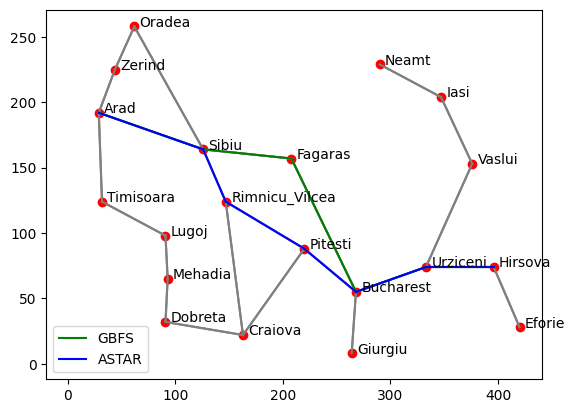

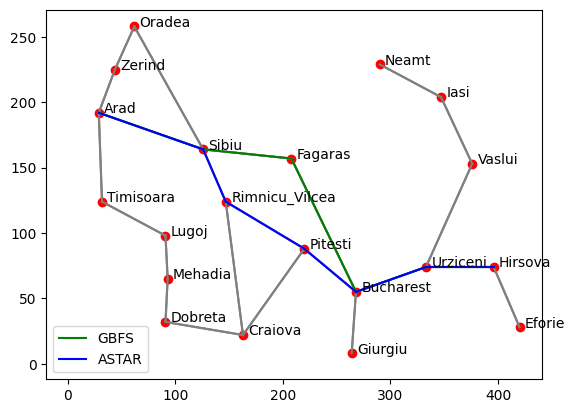

Nhập đỉnh bắt đầu: 11
Nhập đỉnh kết thúc: 8
GBFS =>  ['Mehadia', 'Dobreta', 'Craiova', 'Pitesti', 'Bucharest', 'Urziceni', 'Hirsova']
ASTAR =>  ['Mehadia', 'Lugoj', 'Timisoara', 'Arad', 'Sibiu', 'Rimnicu_Vilcea', 'Pitesti', 'Bucharest', 'Urziceni', 'Hirsova']
GBFS_fixed =>  ['Mehadia', 'Dobreta', 'Craiova', 'Pitesti', 'Bucharest', 'Urziceni', 'Hirsova']
ASTAR_fixed =>  ['Mehadia', 'Dobreta', 'Craiova', 'Pitesti', 'Bucharest', 'Urziceni', 'Hirsova']


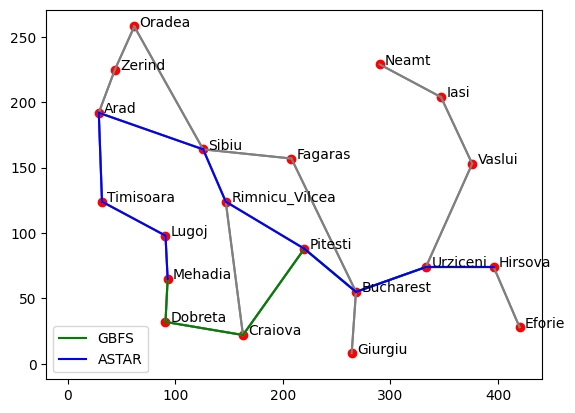

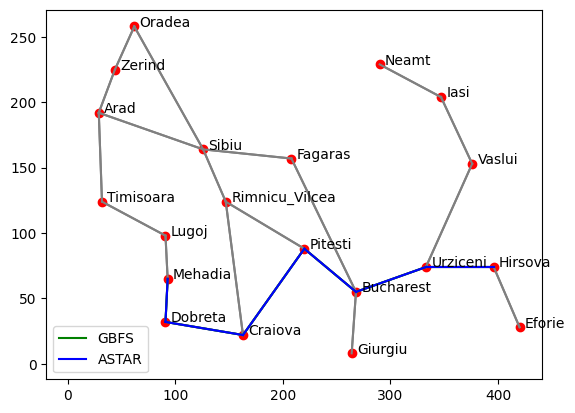

Nhập đỉnh bắt đầu: 17
Nhập đỉnh kết thúc: 8
GBFS =>  ['Timisoara', 'Lugoj', 'Mehadia', 'Dobreta', 'Craiova', 'Pitesti', 'Bucharest', 'Urziceni', 'Hirsova']
ASTAR =>  ['Timisoara', 'Lugoj', 'Mehadia', 'Dobreta', 'Craiova', 'Pitesti', 'Bucharest', 'Urziceni', 'Hirsova']
GBFS_fixed =>  ['Timisoara', 'Lugoj', 'Mehadia', 'Dobreta', 'Craiova', 'Pitesti', 'Bucharest', 'Urziceni', 'Hirsova']
ASTAR_fixed =>  ['Timisoara', 'Arad', 'Sibiu', 'Rimnicu_Vilcea', 'Pitesti', 'Bucharest', 'Urziceni', 'Hirsova']


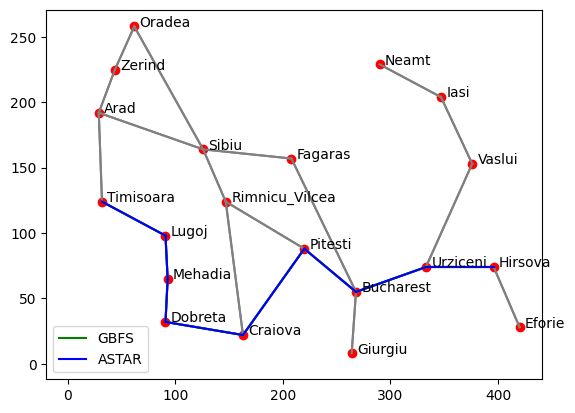

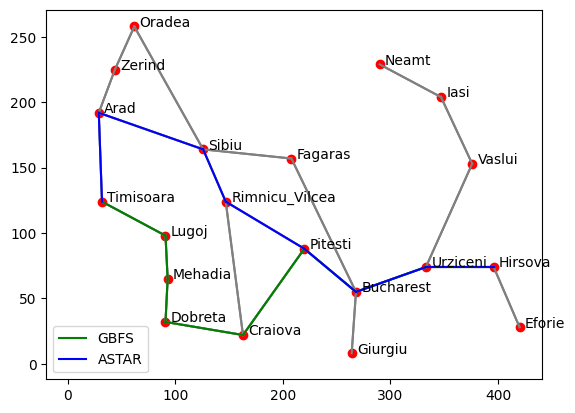

Nhập đỉnh bắt đầu: 0
Nhập đỉnh kết thúc: 0


In [16]:

if __name__ == "__main__":
    heuristic = getHeuristics()
    graph = createGraph()
    city, citiesCode = getCity()

    for i, j in citiesCode.items():
        print(i, j)

    while True:
        inputCode1 = int(input("Nhập đỉnh bắt đầu: "))
        inputCode2 = int(input("Nhập đỉnh kết thúc: "))

        if inputCode1 == 0 or inputCode2 == 0:
            break

        startCity = citiesCode[inputCode1]
        endCity = citiesCode[inputCode2]

        gbfs = GBFS(startCity, heuristic, graph, endCity)
        astar = Astar(startCity, heuristic, graph, endCity)
        print("GBFS => ", gbfs)
        print("ASTAR => ", astar)

        gbfs_custom = GBFS_custom(startCity, heuristic, graph, endCity)
        astar_custom = Astar_custom(startCity, heuristic, graph, endCity)

        print("GBFS_fixed => ", gbfs_custom)
        print("ASTAR_fixed => ", astar_custom)

        drawMap(city, gbfs, astar, graph)
        drawMap(city, gbfs_custom, astar_custom, graph)


